In [7]:
# Import Package
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
import sklearn.preprocessing as preprocessing
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from  subprocess import check_call
import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None
pd.options.display.width = None

In [8]:
def printStatistic(newdf):
    print(newdf.head())
    print()
    print(newdf.info())
    print()
    for col in newdf:
        print(newdf[col].unique())
    print()


In [9]:
# preprocessing
class Preprocess:
    def __init__(self):
        self.mydf = df.copy()

    def drop(self, col, str):
        idx = self.mydf[self.mydf[col] == str].index
        self.mydf.drop(idx, axis='index', inplace=True)

    def reset(self, col):
        self.mydf = self.mydf.astype('int')
        self.mydf.set_index(self.mydf[col], inplace=True)

    def getDf(self):
        return self.mydf


In [10]:
# Modeling
class Model:
    def __init__(self, ndf, sIdx, eIdx, ratio):
        self.mydf = ndf.copy()
        self.X = self.mydf.iloc[:, sIdx:eIdx]
        self.Y = self.mydf.iloc[:, eIdx]
        self.ratio = ratio
        self.xTrain, self.xTest, self.yTrain, self.yTest = train_test_split(self.X, self.Y, test_size=self.ratio, shuffle=True, random_state=35)
        self.m = None
        self.model = None
        self.params = None
        self.grid = None
        self.em = None
        self.yTrainPred = None
        self.yTestPred = None

    def setModel(self, m):
        self.m = m
        if self.m == 'DecisionTreeEntropy':
            self.DecisionTreeEntropy()
        elif self.m == 'DecisionTreeGini':
            self.DecisionTreeGini()
        elif self.m == 'LogisticRegression':
            self.LogisticRegression()
        elif self.m == 'SVM':
            self.SVM()
        else:
            self.model = None
            self.params = None

    # Decision tree - using entropy
    def DecisionTreeEntropy(self):
        self.model = DecisionTreeClassifier()
        self.params = {
            'criterion': ['entropy'],
            'max_depth': [2, 3],
            'min_samples_split': [2, 3]
        }

    # Decision tree - using Gini index
    def DecisionTreeGini(self):
        self.model = DecisionTreeClassifier()
        self.params = {
            'criterion': ['gini'],
            'max_depth': [2, 3],
            'min_samples_split': [2, 3]
        }

    # Logistic regression
    def LogisticRegression(self):
        self.model = LogisticRegression()
        self.params = {
            'penalty': ['l1', 'l2', 'elasticnet'],
            'C': [0.01, 0.1, 1, 5, 10],
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
            'max_iter': [100, 1000]
        }

    # Support vector machine
    def SVM(self):
        self.model = SVC()
        self.params = {
            'kernel': ['rbf'],
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'gamma': [0.001, 0.01, 0.1, 1, 10, 100]
        }
    # standard scaling
    def scaling(self):
        scaler = preprocessing.StandardScaler()
        scaler.fit(self.xTrain)
        self.xTrain = scaler.transform(self.xTrain)
        self.xTest = scaler.transform(self.xTest)

    # hyperparameter tunig - gridSearch : We find the best combination of some of the potential parameters we've designated
    def gridSearch(self):
        self.grid = GridSearchCV(self.model, param_grid=self.params, cv=3, refit=True)
        self.grid.fit(self.xTrain, self.yTrain)

        self.em = self.grid.best_estimator_
        self.yTrainPred = self.em.predict(self.xTrain)  # Predict using xTrain
        self.yTestPred = self.em.predict(self.xTest)  # Predict using xTest

    def printAcc(self):
        print("<< Modeling Result >>")

        scores = pd.DataFrame(self.grid.cv_results_)
        scores = scores.sort_values(by=["rank_test_score"])
        scores = scores.set_index(
            scores["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
        ).rename_axis("hyperparameter")
        print(scores[["params", "rank_test_score", "mean_test_score"]])
        print()

        scores = scores.iloc[:3]
        model_scores = scores.filter(regex=r"split\d*_test_score")
        fig, ax = plt.subplots()
        sns.lineplot(
            data=model_scores.transpose().iloc[:3],
            dashes=False,
            palette="Set1",
            marker="o",
            alpha=0.5,
            ax=ax,
        )
        plt.title("For the top 3 mean_test_scores")
        ax.set_xlabel("CV test fold", size=12, labelpad=10)
        ax.set_ylabel("Model AUC", size=12)
        ax.tick_params(bottom=True, labelbottom=False)
        plt.show()

        print('> best parameters:', self.grid.best_params_)
        print('> best score:', self.grid.best_score_)
        print('> best estimator:', self.em)
        print("> Train Accuracy: {}".format(accuracy_score(self.yTrain, self.yTrainPred)))
        print("> Test Accuracy: {}".format(accuracy_score(self.yTest, self.yTestPred)))
        print()

        if self.m == 'DecisionTreeEntropy' or self.m == 'DecisionTreeGini':
            # Make the tree visualization and store
            export_graphviz(self.em, out_file="{} tree(ratio={}).dot".format(self.m, self.ratio),
                            feature_names=self.X.columns, class_names=self.Y.name,
                            filled=True, impurity=False)
            check_call(['dot', '-Tpng', "{} tree(ratio={}).dot".format(self.m, self.ratio), '-o',
                        "{} tree(ratio={}).png".format(self.m, self.ratio)])

    def test(self):
        print("<< Testing Result with best parameter >>")
        k = [3, 5]
        for i in range(len(k)):
            kfold = KFold(n_splits=k[i], shuffle=True, random_state=32)
            score = cross_val_score(self.em, self.X, self.Y, scoring='accuracy', cv=kfold)
            print("> k={} each accuracy : {}".format(k[i], score))
            print("> k={} average accuracy accuracy: {}".format(k[i], np.mean(score)))


In [11]:
# read data file 
df = pd.read_csv('breast-cancer-wisconsin.data', header=None)
df.columns = ['id', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'class']
printStatistic(df)

        id  2  3  4  5  6   7  8  9  10  class
0  1000025  5  1  1  1  2   1  3  1   1      2
1  1002945  5  4  4  5  7  10  3  2   1      2
2  1015425  3  1  1  1  2   2  3  1   1      2
3  1016277  6  8  8  1  3   4  3  7   1      2
4  1017023  4  1  1  3  2   1  3  1   1      2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      699 non-null    int64 
 1   2       699 non-null    int64 
 2   3       699 non-null    int64 
 3   4       699 non-null    int64 
 4   5       699 non-null    int64 
 5   6       699 non-null    int64 
 6   7       699 non-null    object
 7   8       699 non-null    int64 
 8   9       699 non-null    int64 
 9   10      699 non-null    int64 
 10  class   699 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.2+ KB
None

[ 1000025  1002945  1015425  1016277  1017023  1017122  1018099  1018561
  1033078  10

In [12]:
df1 = Preprocess()
df1.drop('7', '?')
df1.reset('id')
df1 = df1.getDf()
printStatistic(df1)

              id  2  3  4  5  6   7  8  9  10  class
id                                                  
1000025  1000025  5  1  1  1  2   1  3  1   1      2
1002945  1002945  5  4  4  5  7  10  3  2   1      2
1015425  1015425  3  1  1  1  2   2  3  1   1      2
1016277  1016277  6  8  8  1  3   4  3  7   1      2
1017023  1017023  4  1  1  3  2   1  3  1   1      2

<class 'pandas.core.frame.DataFrame'>
Int64Index: 683 entries, 1000025 to 897471
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      683 non-null    int64
 1   2       683 non-null    int64
 2   3       683 non-null    int64
 3   4       683 non-null    int64
 4   5       683 non-null    int64
 5   6       683 non-null    int64
 6   7       683 non-null    int64
 7   8       683 non-null    int64
 8   9       683 non-null    int64
 9   10      683 non-null    int64
 10  class   683 non-null    int64
dtypes: int64(11)
memory usage: 64.0 KB
None

[ 1000025  10

===== model: DecisionTreeEntropy, test_ratio = 0.1 ==================
----- Result for unscaled X -------------
<< Modeling Result >>
                                                           params  \
hyperparameter                                                      
entropy_3_2     {'criterion': 'entropy', 'max_depth': 3, 'min_...   
entropy_3_3     {'criterion': 'entropy', 'max_depth': 3, 'min_...   
entropy_2_2     {'criterion': 'entropy', 'max_depth': 2, 'min_...   
entropy_2_3     {'criterion': 'entropy', 'max_depth': 2, 'min_...   

                rank_test_score  mean_test_score  
hyperparameter                                    
entropy_3_2                   1         0.946270  
entropy_3_3                   2         0.944644  
entropy_2_2                   3         0.912084  
entropy_2_3                   3         0.912084  



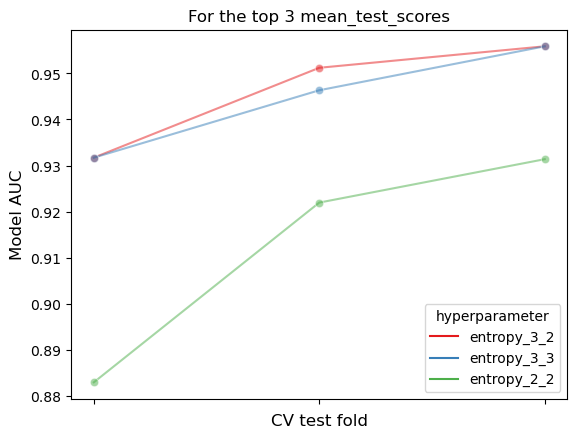

> best parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2}
> best score: 0.9462697274031564
> best estimator: DecisionTreeClassifier(criterion='entropy', max_depth=3)
> Train Accuracy: 0.9609120521172638
> Test Accuracy: 0.927536231884058

<< Testing Result with best parameter >>
> k=3 each accuracy : [0.93859649 0.94736842 0.95154185]
> k=3 average accuracy accuracy: 0.9458355875003219
> k=5 each accuracy : [0.9270073  0.95620438 0.94890511 0.95588235 0.94852941]
> k=5 average accuracy accuracy: 0.9473057106054101
-----------------------------------------
----- Result for scaled X ---------------
<< Modeling Result >>
                                                           params  \
hyperparameter                                                      
entropy_3_3     {'criterion': 'entropy', 'max_depth': 3, 'min_...   
entropy_3_2     {'criterion': 'entropy', 'max_depth': 3, 'min_...   
entropy_2_2     {'criterion': 'entropy', 'max_depth': 2, 'min_...   
ent

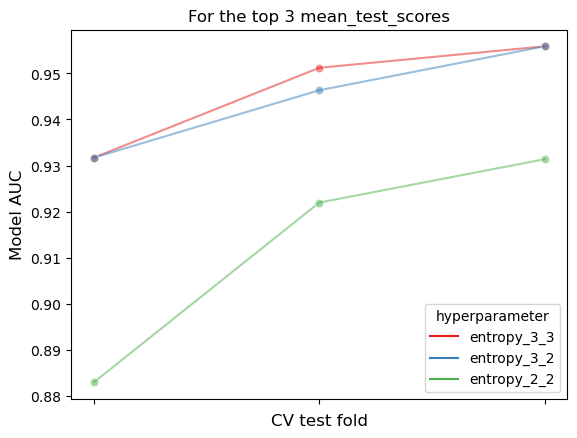

> best parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 3}
> best score: 0.9462697274031564
> best estimator: DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=3)
> Train Accuracy: 0.9609120521172638
> Test Accuracy: 0.9130434782608695

<< Testing Result with best parameter >>
> k=3 each accuracy : [0.93859649 0.94736842 0.95154185]
> k=3 average accuracy accuracy: 0.9458355875003219
> k=5 each accuracy : [0.93430657 0.95620438 0.94890511 0.95588235 0.92647059]
> k=5 average accuracy accuracy: 0.9443537999141263
-----------------------------------------

===== model: DecisionTreeEntropy, test_ratio = 0.2 ==================
----- Result for unscaled X -------------
<< Modeling Result >>
                                                           params  \
hyperparameter                                                      
entropy_3_2     {'criterion': 'entropy', 'max_depth': 3, 'min_...   
entropy_3_3     {'criterion': 'entropy', 'max_de

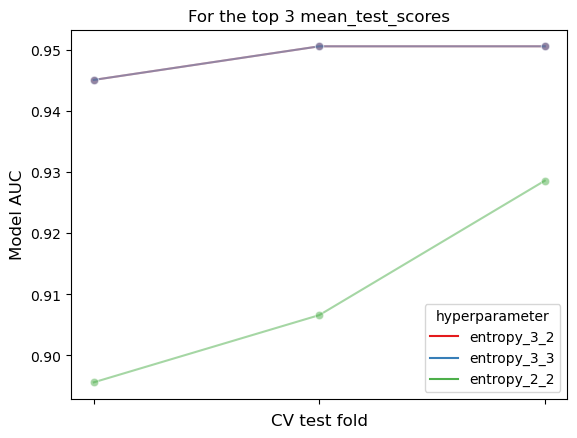

> best parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2}
> best score: 0.9487179487179486
> best estimator: DecisionTreeClassifier(criterion='entropy', max_depth=3)
> Train Accuracy: 0.9652014652014652
> Test Accuracy: 0.9197080291970803

<< Testing Result with best parameter >>
> k=3 each accuracy : [0.93859649 0.94736842 0.95154185]
> k=3 average accuracy accuracy: 0.9458355875003219
> k=5 each accuracy : [0.9270073  0.95620438 0.94890511 0.95588235 0.92647059]
> k=5 average accuracy accuracy: 0.9428939458995277
-----------------------------------------
----- Result for scaled X ---------------
<< Modeling Result >>
                                                           params  \
hyperparameter                                                      
entropy_3_2     {'criterion': 'entropy', 'max_depth': 3, 'min_...   
entropy_3_3     {'criterion': 'entropy', 'max_depth': 3, 'min_...   
entropy_2_2     {'criterion': 'entropy', 'max_depth': 2, 'min_...   
en

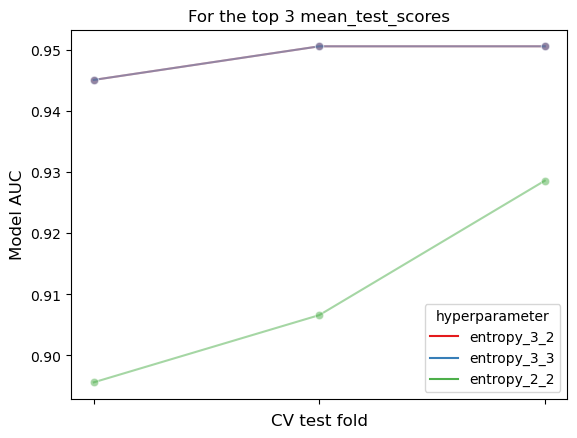

> best parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2}
> best score: 0.9487179487179486
> best estimator: DecisionTreeClassifier(criterion='entropy', max_depth=3)
> Train Accuracy: 0.9652014652014652
> Test Accuracy: 0.9197080291970803

<< Testing Result with best parameter >>
> k=3 each accuracy : [0.93859649 0.94736842 0.95154185]
> k=3 average accuracy accuracy: 0.9458355875003219
> k=5 each accuracy : [0.9270073  0.95620438 0.94890511 0.95588235 0.94852941]
> k=5 average accuracy accuracy: 0.9473057106054101
-----------------------------------------

===== model: DecisionTreeEntropy, test_ratio = 0.3 ==================
----- Result for unscaled X -------------
<< Modeling Result >>
                                                           params  \
hyperparameter                                                      
entropy_3_3     {'criterion': 'entropy', 'max_depth': 3, 'min_...   
entropy_3_2     {'criterion': 'entropy', 'max_depth': 3, 'min_...   


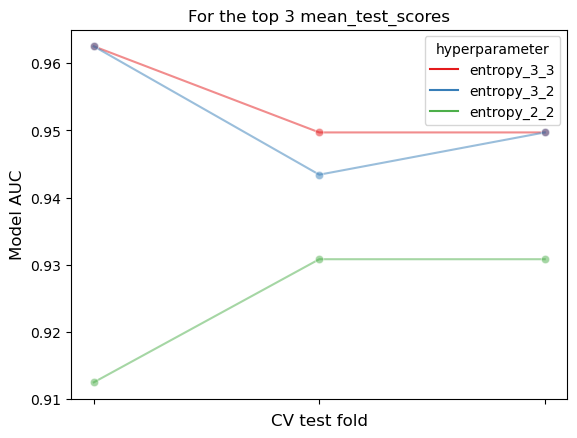

> best parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 3}
> best score: 0.9539570230607967
> best estimator: DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=3)
> Train Accuracy: 0.9707112970711297
> Test Accuracy: 0.9512195121951219

<< Testing Result with best parameter >>
> k=3 each accuracy : [0.93859649 0.94736842 0.95154185]
> k=3 average accuracy accuracy: 0.9458355875003219
> k=5 each accuracy : [0.93430657 0.95620438 0.94890511 0.95588235 0.92647059]
> k=5 average accuracy accuracy: 0.9443537999141263
-----------------------------------------
----- Result for scaled X ---------------
<< Modeling Result >>
                                                           params  \
hyperparameter                                                      
entropy_3_2     {'criterion': 'entropy', 'max_depth': 3, 'min_...   
entropy_3_3     {'criterion': 'entropy', 'max_depth': 3, 'min_...   
entropy_2_2     {'criterion': 'entropy', 'max_dept

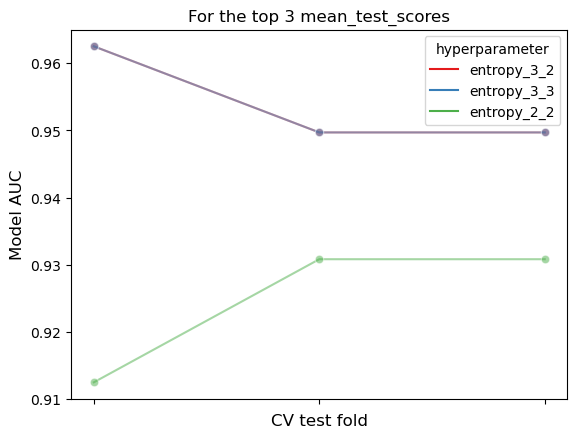

> best parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2}
> best score: 0.9539570230607967
> best estimator: DecisionTreeClassifier(criterion='entropy', max_depth=3)
> Train Accuracy: 0.9707112970711297
> Test Accuracy: 0.9512195121951219

<< Testing Result with best parameter >>
> k=3 each accuracy : [0.93859649 0.94736842 0.95154185]
> k=3 average accuracy accuracy: 0.9458355875003219
> k=5 each accuracy : [0.93430657 0.95620438 0.94890511 0.95588235 0.92647059]
> k=5 average accuracy accuracy: 0.9443537999141263
-----------------------------------------

===== model: DecisionTreeGini, test_ratio = 0.1 ==================
----- Result for unscaled X -------------
<< Modeling Result >>
                                                           params  \
hyperparameter                                                      
gini_3_2        {'criterion': 'gini', 'max_depth': 3, 'min_sam...   
gini_3_3        {'criterion': 'gini', 'max_depth': 3, 'min_sam...   
gin

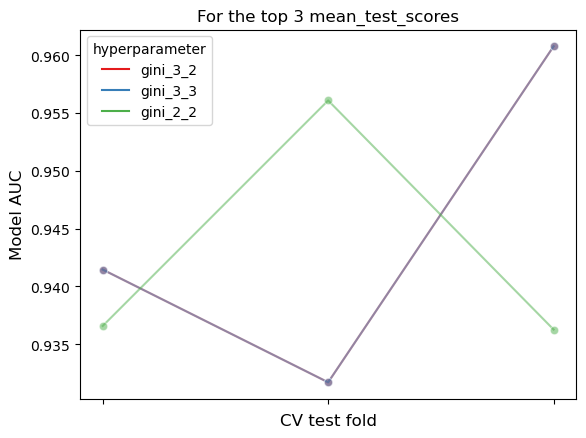

> best parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2}
> best score: 0.9446516818109357
> best estimator: DecisionTreeClassifier(max_depth=3)
> Train Accuracy: 0.9592833876221498
> Test Accuracy: 0.9565217391304348

<< Testing Result with best parameter >>
> k=3 each accuracy : [0.93859649 0.92982456 0.94713656]
> k=3 average accuracy accuracy: 0.9385192055027437
> k=5 each accuracy : [0.94890511 0.94890511 0.9270073  0.91911765 0.94117647]
> k=5 average accuracy accuracy: 0.9370223271790467
-----------------------------------------
----- Result for scaled X ---------------
<< Modeling Result >>
                                                           params  \
hyperparameter                                                      
gini_3_2        {'criterion': 'gini', 'max_depth': 3, 'min_sam...   
gini_3_3        {'criterion': 'gini', 'max_depth': 3, 'min_sam...   
gini_2_2        {'criterion': 'gini', 'max_depth': 2, 'min_sam...   
gini_2_3        {'criterio

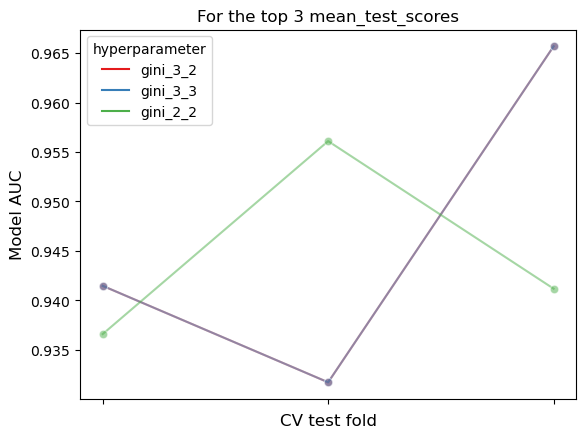

> best parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2}
> best score: 0.9462856687390403
> best estimator: DecisionTreeClassifier(max_depth=3)
> Train Accuracy: 0.9592833876221498
> Test Accuracy: 0.9565217391304348

<< Testing Result with best parameter >>
> k=3 each accuracy : [0.93859649 0.92982456 0.94713656]
> k=3 average accuracy accuracy: 0.9385192055027437
> k=5 each accuracy : [0.94890511 0.94890511 0.9270073  0.92647059 0.94117647]
> k=5 average accuracy accuracy: 0.9384929154143409
-----------------------------------------

===== model: DecisionTreeGini, test_ratio = 0.2 ==================
----- Result for unscaled X -------------
<< Modeling Result >>
                                                           params  \
hyperparameter                                                      
gini_2_2        {'criterion': 'gini', 'max_depth': 2, 'min_sam...   
gini_2_3        {'criterion': 'gini', 'max_depth': 2, 'min_sam...   
gini_3_3        {'criterion

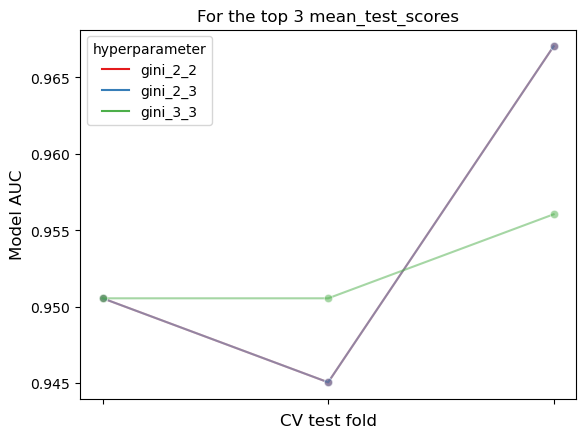

> best parameters: {'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 2}
> best score: 0.9542124542124543
> best estimator: DecisionTreeClassifier(max_depth=2)
> Train Accuracy: 0.9578754578754579
> Test Accuracy: 0.927007299270073

<< Testing Result with best parameter >>
> k=3 each accuracy : [0.93421053 0.93421053 0.95154185]
> k=3 average accuracy accuracy: 0.9399876342839478
> k=5 each accuracy : [0.91240876 0.9270073  0.9270073  0.91911765 0.95588235]
> k=5 average accuracy accuracy: 0.9282846715328466
-----------------------------------------
----- Result for scaled X ---------------
<< Modeling Result >>
                                                           params  \
hyperparameter                                                      
gini_2_2        {'criterion': 'gini', 'max_depth': 2, 'min_sam...   
gini_2_3        {'criterion': 'gini', 'max_depth': 2, 'min_sam...   
gini_3_2        {'criterion': 'gini', 'max_depth': 3, 'min_sam...   
gini_3_3        {'criterion

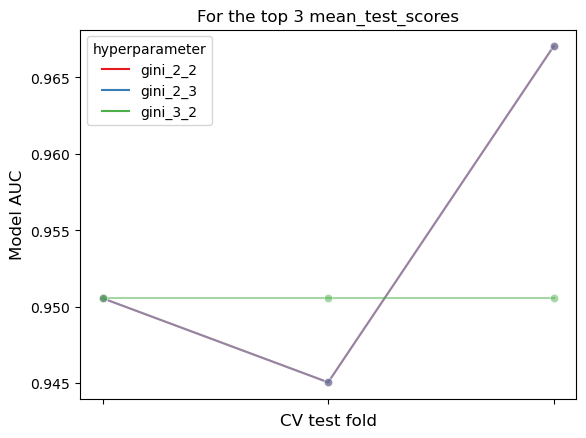

> best parameters: {'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 2}
> best score: 0.9542124542124543
> best estimator: DecisionTreeClassifier(max_depth=2)
> Train Accuracy: 0.9578754578754579
> Test Accuracy: 0.927007299270073

<< Testing Result with best parameter >>
> k=3 each accuracy : [0.93421053 0.93421053 0.95154185]
> k=3 average accuracy accuracy: 0.9399876342839478
> k=5 each accuracy : [0.91240876 0.9270073  0.9270073  0.91911765 0.95588235]
> k=5 average accuracy accuracy: 0.9282846715328466
-----------------------------------------

===== model: DecisionTreeGini, test_ratio = 0.3 ==================
----- Result for unscaled X -------------
<< Modeling Result >>
                                                           params  \
hyperparameter                                                      
gini_3_3        {'criterion': 'gini', 'max_depth': 3, 'min_sam...   
gini_3_2        {'criterion': 'gini', 'max_depth': 3, 'min_sam...   
gini_2_2        {'criterion'

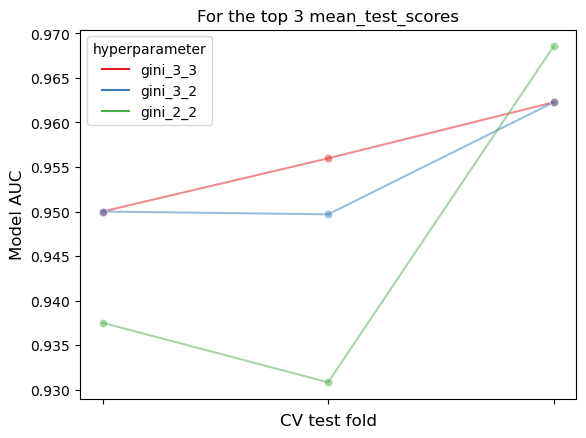

> best parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 3}
> best score: 0.9560796645702306
> best estimator: DecisionTreeClassifier(max_depth=3, min_samples_split=3)
> Train Accuracy: 0.9707112970711297
> Test Accuracy: 0.9512195121951219

<< Testing Result with best parameter >>
> k=3 each accuracy : [0.93859649 0.92982456 0.94713656]
> k=3 average accuracy accuracy: 0.9385192055027437
> k=5 each accuracy : [0.94890511 0.94890511 0.9270073  0.92647059 0.94117647]
> k=5 average accuracy accuracy: 0.9384929154143409
-----------------------------------------
----- Result for scaled X ---------------
<< Modeling Result >>
                                                           params  \
hyperparameter                                                      
gini_3_2        {'criterion': 'gini', 'max_depth': 3, 'min_sam...   
gini_3_3        {'criterion': 'gini', 'max_depth': 3, 'min_sam...   
gini_2_2        {'criterion': 'gini', 'max_depth': 2, 'min_sam...   
gini_

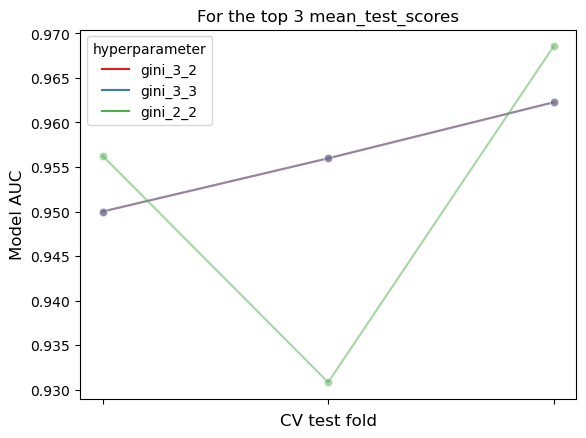

> best parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2}
> best score: 0.9560796645702306
> best estimator: DecisionTreeClassifier(max_depth=3)
> Train Accuracy: 0.9707112970711297
> Test Accuracy: 0.9463414634146341

<< Testing Result with best parameter >>
> k=3 each accuracy : [0.93859649 0.92982456 0.94713656]
> k=3 average accuracy accuracy: 0.9385192055027437
> k=5 each accuracy : [0.94890511 0.94890511 0.91970803 0.91911765 0.94117647]
> k=5 average accuracy accuracy: 0.9355624731644483
-----------------------------------------

===== model: LogisticRegression, test_ratio = 0.1 ==================
----- Result for unscaled X -------------
<< Modeling Result >>
                                                                          params  \
hyperparameter                                                                     
10_100_l1_liblinear            {'C': 10, 'max_iter': 100, 'penalty': 'l1', 's...   
1_100_l2_newton-cg             {'C': 1, 'max_iter

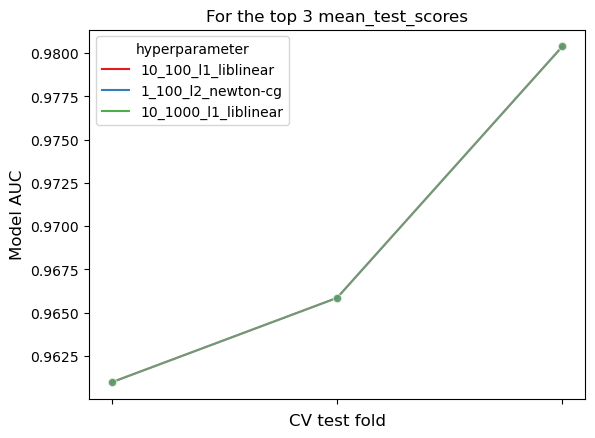

> best parameters: {'C': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
> best score: 0.9690738083851427
> best estimator: LogisticRegression(C=1, solver='newton-cg')
> Train Accuracy: 0.9706840390879479
> Test Accuracy: 0.9855072463768116

<< Testing Result with best parameter >>
> k=3 each accuracy : [0.96929825 0.96929825 0.969163  ]
> k=3 average accuracy accuracy: 0.9692531622742613
> k=5 each accuracy : [0.95620438 0.97810219 0.97080292 0.96323529 0.97794118]
> k=5 average accuracy accuracy: 0.9692571919278661
-----------------------------------------
----- Result for scaled X ---------------
<< Modeling Result >>
                                                                          params  \
hyperparameter                                                                     
1_1000_l1_saga                 {'C': 1, 'max_iter': 1000, 'penalty': 'l1', 's...   
1_100_l1_saga                  {'C': 1, 'max_iter': 100, 'penalty': 'l1', 'so...   
10_100_l1_liblinear    

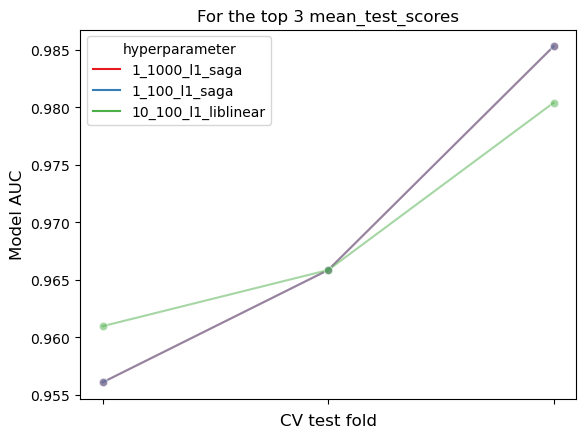

> best parameters: {'C': 1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}
> best score: 0.9690817790530847
> best estimator: LogisticRegression(C=1, penalty='l1', solver='saga')
> Train Accuracy: 0.9706840390879479
> Test Accuracy: 0.9855072463768116

<< Testing Result with best parameter >>
> k=3 each accuracy : [0.64473684 0.62719298 0.6784141 ]
> k=3 average accuracy accuracy: 0.6501146404925677
> k=5 each accuracy : [0.6350365  0.60583942 0.69343066 0.625      0.69117647]
> k=5 average accuracy accuracy: 0.6500966079862602
-----------------------------------------

===== model: LogisticRegression, test_ratio = 0.2 ==================
----- Result for unscaled X -------------
<< Modeling Result >>
                                                                          params  \
hyperparameter                                                                     
10_100_l1_liblinear            {'C': 10, 'max_iter': 100, 'penalty': 'l1', 's...   
0.1_1000_l2_newton-cg          {'

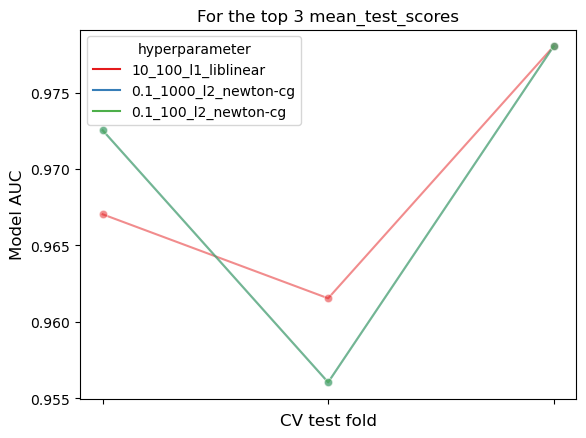

> best parameters: {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
> best score: 0.9688644688644689
> best estimator: LogisticRegression(C=0.1, solver='newton-cg')
> Train Accuracy: 0.9706959706959707
> Test Accuracy: 0.9708029197080292

<< Testing Result with best parameter >>
> k=3 each accuracy : [0.97368421 0.97368421 0.96475771]
> k=3 average accuracy accuracy: 0.9707087101012443
> k=5 each accuracy : [0.95620438 0.97810219 0.97080292 0.97058824 0.97794118]
> k=5 average accuracy accuracy: 0.9707277801631602
-----------------------------------------
----- Result for scaled X ---------------
<< Modeling Result >>
                                                                          params  \
hyperparameter                                                                     
0.1_100_l2_saga                {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', '...   
5_100_l1_saga                  {'C': 5, 'max_iter': 100, 'penalty': 'l1', 'so...   
0.1_100_l2_sag     

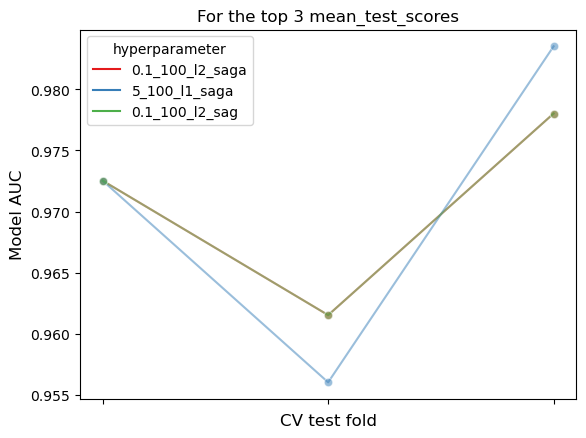

> best parameters: {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
> best score: 0.9706959706959707
> best estimator: LogisticRegression(C=0.1, solver='newton-cg')
> Train Accuracy: 0.9725274725274725
> Test Accuracy: 0.9708029197080292

<< Testing Result with best parameter >>
> k=3 each accuracy : [0.97368421 0.97368421 0.96475771]
> k=3 average accuracy accuracy: 0.9707087101012443
> k=5 each accuracy : [0.95620438 0.97810219 0.97080292 0.97058824 0.97794118]
> k=5 average accuracy accuracy: 0.9707277801631602
-----------------------------------------

===== model: LogisticRegression, test_ratio = 0.3 ==================
----- Result for unscaled X -------------
<< Modeling Result >>
                                                                          params  \
hyperparameter                                                                     
0.01_1000_l2_newton-cg         {'C': 0.01, 'max_iter': 1000, 'penalty': 'l2',...   
0.01_100_l2_newton-cg          {'

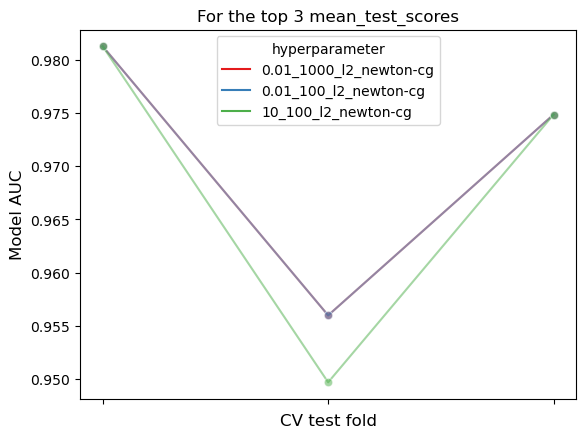

> best parameters: {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
> best score: 0.9706892033542976
> best estimator: LogisticRegression(C=0.01, solver='newton-cg')
> Train Accuracy: 0.9748953974895398
> Test Accuracy: 0.9609756097560975

<< Testing Result with best parameter >>
> k=3 each accuracy : [0.96052632 0.96052632 0.96475771]
> k=3 average accuracy accuracy: 0.961936780276683
> k=5 each accuracy : [0.94890511 0.96350365 0.95620438 0.97058824 0.97058824]
> k=5 average accuracy accuracy: 0.9619579218548735
-----------------------------------------
----- Result for scaled X ---------------
<< Modeling Result >>
                                                                          params  \
hyperparameter                                                                     
1_1000_l1_saga                 {'C': 1, 'max_iter': 1000, 'penalty': 'l1', 's...   
0.01_1000_l2_liblinear         {'C': 0.01, 'max_iter': 1000, 'penalty': 'l2',...   
0.1_1000_l2_liblin

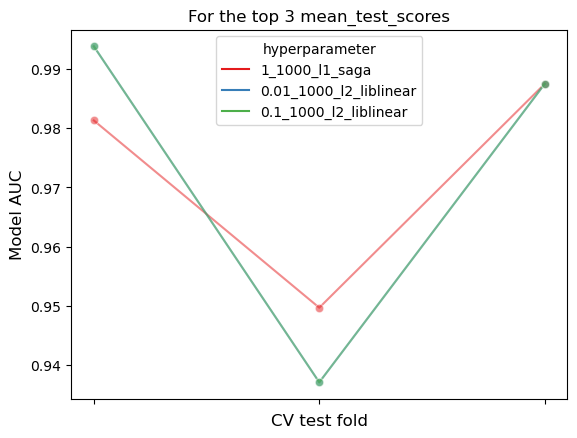

> best parameters: {'C': 1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}
> best score: 0.9727856394129978
> best estimator: LogisticRegression(C=1, max_iter=1000, penalty='l1', solver='saga')
> Train Accuracy: 0.9769874476987448
> Test Accuracy: 0.9658536585365853

<< Testing Result with best parameter >>
> k=3 each accuracy : [0.64473684 0.62719298 0.6784141 ]
> k=3 average accuracy accuracy: 0.6501146404925677
> k=5 each accuracy : [0.6350365  0.60583942 0.69343066 0.625      0.69117647]
> k=5 average accuracy accuracy: 0.6500966079862602
-----------------------------------------

===== model: SVM, test_ratio = 0.1 ==================
----- Result for unscaled X -------------
<< Modeling Result >>
                                                        params  \
hyperparameter                                                   
1_0.001_rbf          {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}   
100_0.001_rbf      {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}   
10_0.001_rbf        

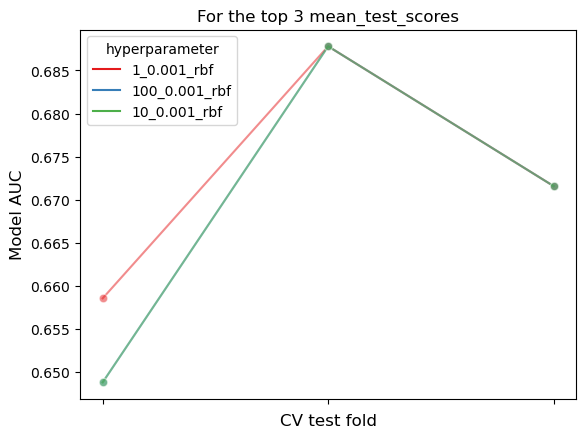

> best parameters: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
> best score: 0.6726366969552048
> best estimator: SVC(C=1, gamma=0.001)
> Train Accuracy: 0.9837133550488599
> Test Accuracy: 0.6231884057971014

<< Testing Result with best parameter >>
> k=3 each accuracy : [0.64912281 0.64912281 0.6784141 ]
> k=3 average accuracy accuracy: 0.658886570317129
> k=5 each accuracy : [0.65693431 0.61313869 0.73722628 0.625      0.69852941]
> k=5 average accuracy accuracy: 0.6661657363675397
-----------------------------------------
----- Result for scaled X ---------------
<< Modeling Result >>
                                                        params  \
hyperparameter                                                   
10_0.001_rbf        {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}   
1_0.01_rbf            {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}   
10_0.01_rbf          {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}   
100_0.001_rbf      {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}   
1_0.1_rbf 

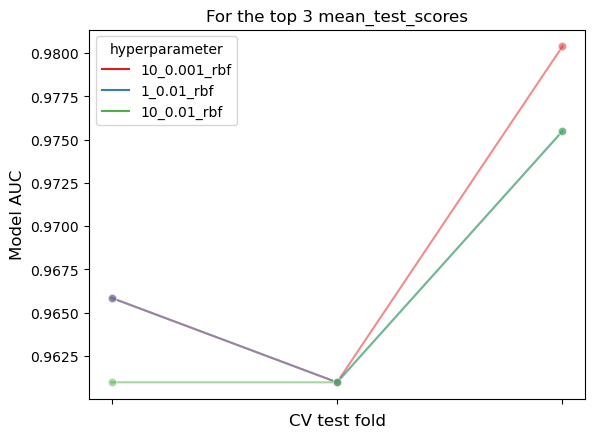

> best parameters: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
> best score: 0.9690738083851427
> best estimator: SVC(C=10, gamma=0.001)
> Train Accuracy: 0.9690553745928339
> Test Accuracy: 0.9855072463768116

<< Testing Result with best parameter >>
> k=3 each accuracy : [0.64912281 0.64912281 0.66519824]
> k=3 average accuracy accuracy: 0.6544812839735168
> k=5 each accuracy : [0.64963504 0.61313869 0.72992701 0.625      0.68382353]
> k=5 average accuracy accuracy: 0.6603048518677544
-----------------------------------------

===== model: SVM, test_ratio = 0.2 ==================
----- Result for unscaled X -------------
<< Modeling Result >>
                                                        params  \
hyperparameter                                                   
1_0.001_rbf          {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}   
100_0.001_rbf      {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}   
10_0.001_rbf        {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}   
100_0.01_rbf      

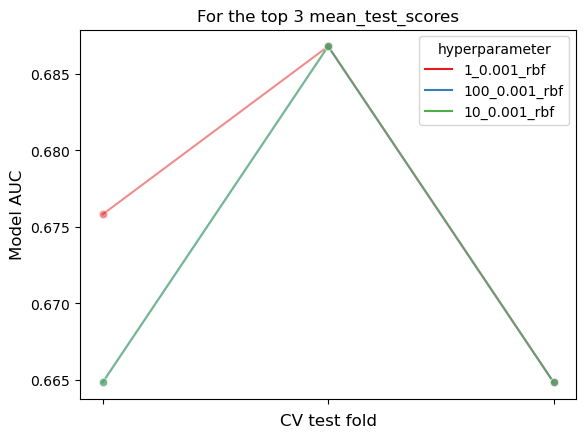

> best parameters: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
> best score: 0.6758241758241758
> best estimator: SVC(C=1, gamma=0.001)
> Train Accuracy: 0.989010989010989
> Test Accuracy: 0.6423357664233577

<< Testing Result with best parameter >>
> k=3 each accuracy : [0.64912281 0.64912281 0.6784141 ]
> k=3 average accuracy accuracy: 0.658886570317129
> k=5 each accuracy : [0.65693431 0.61313869 0.73722628 0.625      0.69852941]
> k=5 average accuracy accuracy: 0.6661657363675397
-----------------------------------------
----- Result for scaled X ---------------
<< Modeling Result >>
                                                        params  \
hyperparameter                                                   
100_0.001_rbf      {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}   
10_0.01_rbf          {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}   
10_0.001_rbf        {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}   
100_0.1_rbf          {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}   
1_0.01_rbf 

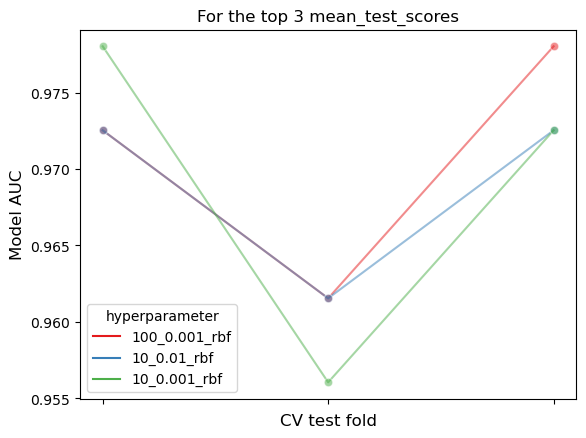

> best parameters: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
> best score: 0.9706959706959707
> best estimator: SVC(C=100, gamma=0.001)
> Train Accuracy: 0.9761904761904762
> Test Accuracy: 0.9781021897810219

<< Testing Result with best parameter >>
> k=3 each accuracy : [0.64912281 0.64912281 0.66519824]
> k=3 average accuracy accuracy: 0.6544812839735168
> k=5 each accuracy : [0.64963504 0.60583942 0.72992701 0.625      0.68382353]
> k=5 average accuracy accuracy: 0.6588449978531559
-----------------------------------------

===== model: SVM, test_ratio = 0.3 ==================
----- Result for unscaled X -------------
<< Modeling Result >>
                                                        params  \
hyperparameter                                                   
100_0.001_rbf      {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}   
1_0.001_rbf          {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}   
10_0.001_rbf        {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}   
100_0.01_rbf    

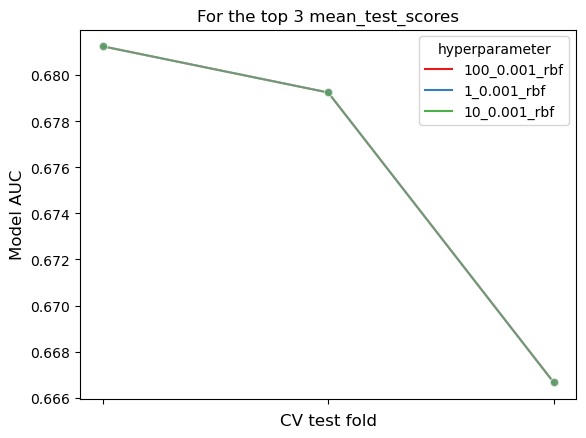

> best parameters: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
> best score: 0.6757206498951782
> best estimator: SVC(C=1, gamma=0.001)
> Train Accuracy: 0.9874476987447699
> Test Accuracy: 0.6487804878048781

<< Testing Result with best parameter >>
> k=3 each accuracy : [0.64912281 0.64912281 0.6784141 ]
> k=3 average accuracy accuracy: 0.658886570317129
> k=5 each accuracy : [0.65693431 0.61313869 0.73722628 0.625      0.69852941]
> k=5 average accuracy accuracy: 0.6661657363675397
-----------------------------------------
----- Result for scaled X ---------------
<< Modeling Result >>
                                                        params  \
hyperparameter                                                   
10_0.001_rbf        {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}   
100_0.001_rbf      {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}   
1_0.01_rbf            {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}   
1_0.1_rbf              {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}   
10_0.01_rb

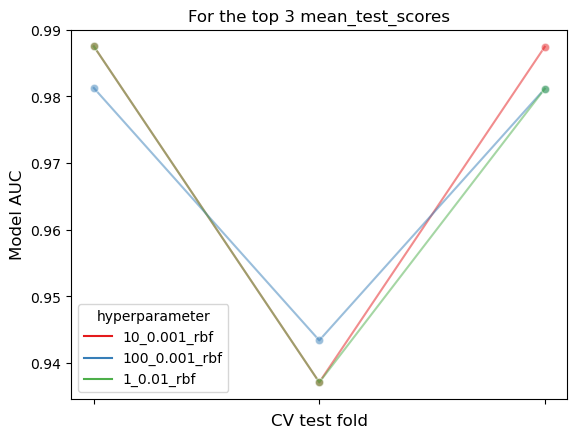

> best parameters: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
> best score: 0.9706761006289307
> best estimator: SVC(C=10, gamma=0.001)
> Train Accuracy: 0.9728033472803347
> Test Accuracy: 0.9658536585365853

<< Testing Result with best parameter >>
> k=3 each accuracy : [0.64912281 0.64912281 0.66519824]
> k=3 average accuracy accuracy: 0.6544812839735168
> k=5 each accuracy : [0.64963504 0.61313869 0.72992701 0.625      0.68382353]
> k=5 average accuracy accuracy: 0.6603048518677544
-----------------------------------------



In [13]:
test_ratio = [0.1, 0.2, 0.3]
lists = ['DecisionTreeEntropy', 'DecisionTreeGini', 'LogisticRegression', 'SVM']

for j in range(len(lists)):
    # Training and Testing using different test ratio of dataset
    for i in range(len(test_ratio)):
        print("===== model: {}, test_ratio = {} ==================".format(lists[j], test_ratio[i]))
        print("----- Result for unscaled X -------------")
        ndf = Model(df1, 0, -1, test_ratio[i])
        ndf.setModel(lists[j])
        ndf.gridSearch()
        ndf.printAcc()
        ndf.test()
        print("-----------------------------------------")

        print("----- Result for scaled X ---------------")
        ndf_scaled = Model(df1, 0, -1, test_ratio[i])
        ndf_scaled.setModel(lists[j])
        ndf_scaled.scaling()
        ndf_scaled.gridSearch()
        ndf_scaled.printAcc()
        ndf_scaled.test()
        print("-----------------------------------------")
        print()
